In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [ ]:
!pip install ultralytics

In [3]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
from ultralytics.utils.plotting import Annotator  # ultralytics.yolo.utils.plotting is deprecated

model = YOLO("/content/drive/MyDrive/basketball_saved_weights/.pt")
video_path = "/content/drive/MyDrive/rr4 (1).mp4"
cap = cv2.VideoCapture(video_path)
cap.set(3, 640)
cap.set(4, 384)
rim_bounding_boxes = []
while True:
    _, img = cap.read()

    # BGR to RGB conversion is performed under the hood
    # see: https://github.com/ultralytics/ultralytics/issues/2575
    results = model.predict(img)

    for r in results:

        annotator = Annotator(img)
        boxes = r.boxes
        classes = r.names
        for box in boxes:

            b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
            print("bounding box is ",b)
            c = box.cls
            print("Name of the classes box is ",classes[int(c[0])])
            if classes[int(c[0])] == 'rim':
              rim_bounding_boxes.append(b)
              break
            annotator.box_label(b, model.names[int(c)])
    if len(rim_bounding_boxes) != 0:
      img = annotator.result()
      #cv2_imshow(img)
      #cap.release()
      #cv2.destroyAllWindows()
      break



0: 384x640 2 persons, 3933.4ms
Speed: 14.9ms preprocess, 3933.4ms inference, 20.2ms postprocess per image at shape (1, 3, 384, 640)
bounding box is  tensor([611.0029, 236.5099, 703.2574, 478.3416])
Name of the classes box is  person
bounding box is  tensor([451.3803, 329.3334, 531.3071, 479.0069])
Name of the classes box is  person

0: 384x640 2 persons, 1 rim, 2553.1ms
Speed: 6.0ms preprocess, 2553.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
bounding box is  tensor([610.4351, 236.1035, 703.7626, 478.4439])
Name of the classes box is  person
bounding box is  tensor([451.5671, 329.2812, 531.3400, 478.9253])
Name of the classes box is  person
bounding box is  tensor([366.2907, 146.3847, 386.9054, 172.0965])
Name of the classes box is  rim


In [30]:
def pixels_locations(bounding_box):
  middlex = float((bounding_box[0][0] + bounding_box[0][2])/2)
  middley = float((bounding_box[0][1] + bounding_box[0][3])/2)
  pix_matrix = np.array([[middlex],[middley],[1]])
  return pix_matrix


In [31]:
pix_matrix =  pixels_locations(rim_bounding_boxes)

In [32]:
pix_matrix

array([[      376.6],
       [     159.24],
       [          1]])

# ***The formula for converting back to the original world***
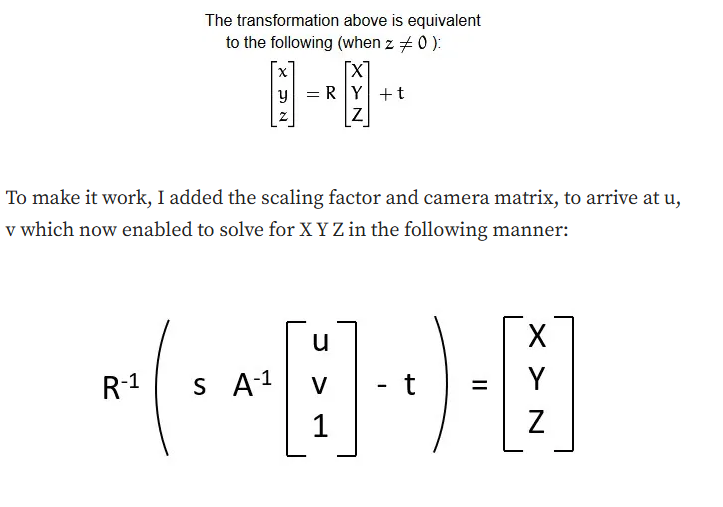

# ***The metrix A for the transportations***

# ***A matrix***
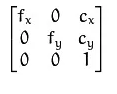

In [36]:
Focal_Length = [ 3660.25174,  3619.33126 ]
Principal_Point = [ 1257.49723,  695.93659 ]
Skew = [ 140.9285210 ]
Distortion = [ -0.122022,  -1.944025 ]
A_matrix = np.array([[Focal_Length[0],0,Principal_Point[0]],
                    [0, Focal_Length[1],Principal_Point[1]],
                    [0, 0,1]])
Matrix_revolutions =  np.array([[-0.0126365,   0.26873036, -0.05893611],[-0.23194018,  0.10050067,  0.25559518],[ 0.11977388,  0.02880981,  0.61499587]])
Matrix_displacement =  np.array([[-0.03636979],[ 0.03707577], [ 0.48344176]])
inverse_newcam_mtx = np.linalg.inv(A_matrix)
inverse_R_mtx = np.linalg.inv(Matrix_revolutions)

In [37]:
out = np.matmul(inverse_newcam_mtx, pix_matrix) - Matrix_displacement

In [41]:
out1 = np.matmul(inverse_R_mtx, out)

In [42]:
print(out1)

[[     1.2425]
 [   -0.56486]
 [    0.62441]]


In [ ]:
#inverse_newcam_mtx = np.linalg.inv(A_matrix)
#inverse_R_mtx = np.linalg.inv(Matrix_revolutions)
#print("Inverse A matrix: ",inverse_newcam_mtx)
#print("Inverse revelotion matrix: ",inverse_R_mtx)

Inverse A matrix:  [[ 0.00027321           0    -0.34355]
 [          0  0.00027629    -0.19228]
 [          0           0           1]]
Inverse revelotion matrix:  [[      1.159     -3.5544      1.5883]
 [     3.6883   -0.015165     0.35976]
 [    -0.3985     0.69295      1.2998]]


In [65]:
def calculating_real_xyz(pixel_xyz):
  Focal_Length = [ 3660.25174,  3619.33126 ]
  Principal_Point = [ 1257.49723,  695.93659 ]
  Skew = [ 140.9285210 ]
  Distortion = [ -0.122022,  -1.944025 ]
  A_matrix = np.array([[Focal_Length[0],0,Principal_Point[0]],
                      [0, Focal_Length[1],Principal_Point[1]],
                      [0, 0,1]])
  Matrix_displacement =  np.array([[-0.03636979],[ 0.03707577], [ 0.48344176]])
  Matrix_revolutions =  np.array([[-0.0126365,   0.26873036, -0.05893611],[-0.23194018,  0.10050067,  0.25559518],[ 0.11977388,  0.02880981,  0.61499587]])
  inverse_newcam_mtx = np.linalg.inv(A_matrix)
  inverse_R_mtx = np.linalg.inv(Matrix_revolutions)
  a1 = np.matmul(inverse_newcam_mtx, pix_matrix) - Matrix_displacement
  a2 = np.matmul(inverse_R_mtx, a1)
  out =[]
  for i, x in zip(np.arange(0,3),a2):
    if i == 0:
      out.append(x*abs(Distortion[0])*(1/np.abs(Distortion[1])))
    if i == 1:
      out.append(np.abs(x)* (1.1/abs(Distortion[0]))* np.abs(Distortion[1]))
    if i == 2:
      out.append(np.abs(x)* abs(Distortion[0]))

  return np.array(out)


In [66]:
real_out = calculating_real_xyz(pix_matrix)

In [67]:
real_out

array([[    0.07799],
       [     9.8991],
       [   0.076192]])

In [68]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

In [72]:
def calculate_metrics(y_real, y_pred):
  print('mse: ', mean_squared_error(y_real, y_pred))
  print('mae: ', mean_absolute_error(y_real, y_pred))

# ***Reference_based_on_the_client_specification for rim***
# ***rim  = [0,10,0]***

In [73]:
reference = np.array([[0],[10],[0]])
calculate_metrics(reference,real_out)

mse:  0.007353842411674231
mae:  0.08501585514738624
